# about all the code below

1. Data was imabalanced, so splits with equal proportions of all classes has to be included in train and test.
2. Data was imabalanced, so multiple weighted evaluation metrics has to be chosen. I have calculated:  
    a. <u>Primary evaluation metric</u>: Weighted harmonic mean using <a href='https://www.tensorflow.org/addons/api_docs/python/tfa/metrics/FBetaScore'><i>F-beta score</i></a>, that gives equal weights to all classes(with average='macro') has been used.  
    b. Accuracy using <a href='https://www.tensorflow.org/api_docs/python/tf/keras/metrics/CategoricalAccuracy'><i>CategoricalAccuracy</i></a>  
    c. Average <b>Precision</b> and <b>Recall</b> has also been calculated.  
3. Becuase of the imbalance in the data, additonal class weights have been supplied to let the algorithm give extra weight to under-sampled classes.  
4. Xception with weights of 'imagenet' has been adopted without including top layers. At final layers, two additional fully connected layers with dropout of 0.5 has been added.

# getting and exploring the data

clean all the above cells for them to be able to run without issues on kaggle when committed

In [1]:
import os
import numpy as np
# set the seed for to make results reproducable
np.random.seed(2)
import pandas as pd


import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style('darkgrid')


from tensorflow.random import set_seed
# set the seed for to make results reproducable
set_seed(2)
from tensorflow.keras.preprocessing.image import ImageDataGenerator

checking the directory structure

In [2]:
!find '../input/fruit-recognition/' -type d -print

../input/fruit-recognition/
../input/fruit-recognition/Mango
../input/fruit-recognition/Plum
../input/fruit-recognition/Kiwi
../input/fruit-recognition/Kiwi/Kiwi C
../input/fruit-recognition/Kiwi/Kiwi B
../input/fruit-recognition/Kiwi/kiwi A
../input/fruit-recognition/Kiwi/Total Number of Kiwi fruit
../input/fruit-recognition/Carambola
../input/fruit-recognition/Tomatoes
../input/fruit-recognition/Orange
../input/fruit-recognition/Peach
../input/fruit-recognition/Apple
../input/fruit-recognition/Apple/Apple B
../input/fruit-recognition/Apple/Total Number of Apples
../input/fruit-recognition/Apple/Apple E
../input/fruit-recognition/Apple/Apple A
../input/fruit-recognition/Apple/Apple D
../input/fruit-recognition/Apple/Apple C
../input/fruit-recognition/Apple/Apple F
../input/fruit-recognition/Persimmon
../input/fruit-recognition/Pear
../input/fruit-recognition/Pitaya
../input/fruit-recognition/Guava
../input/fruit-recognition/Guava/guava total final
../input/fruit-recognition/Guava/guav

In [3]:
def load_images_from_folder(folder, only_path = False, label = ""):
# Load the paths to the images in a directory
# or load the images
    if only_path == False:
        images = []
        for filename in os.listdir(folder):
            img = plt.imread(os.path.join(folder,filename))
            if img is not None:
                images.append(img)
        return images
    else:
        path = []
        for filename in os.listdir(folder):
            img_path = os.path.join(folder,filename)
            if img_path is not None:
                path.append([label,img_path])
        return path

In [4]:
# Load the paths on the images
images = []

dirp = "../input/fruit-recognition/"
# Load the paths on the images
images = []

for f in os.listdir(dirp):
    if "png" in os.listdir(dirp+f)[0]:
        images += load_images_from_folder(dirp+f,True,label = f)
    else: 
        for d in os.listdir(dirp+f):
            images += load_images_from_folder(dirp+f+"/"+d,True,label = f)
            
# Create a dataframe with the paths and the label for each fruit
df = pd.DataFrame(images, columns = ["fruit", "path"])
df.head()

,fruit,path
0,Mango,../input/fruit-recognition/Mango/Mango003328.png
1,Mango,../input/fruit-recognition/Mango/Mango001707.png
2,Mango,../input/fruit-recognition/Mango/Mango004084.png
3,Mango,../input/fruit-recognition/Mango/Mango003197.png
4,Mango,../input/fruit-recognition/Mango/Mango002481.png


In [5]:
df.loc[:,'fruit'].nunique()

15

In [6]:
# Assign to each fruit a specific number
fruit_names = sorted(df.fruit.unique())
mapped_fruit_names = dict(zip([t for t in range(len(fruit_names))], fruit_names))
df["label"] = df["fruit"].map(mapped_fruit_names)
print(mapped_fruit_names)

{0: 'Apple', 1: 'Banana', 2: 'Carambola', 3: 'Guava', 4: 'Kiwi', 5: 'Mango', 6: 'Orange', 7: 'Peach', 8: 'Pear', 9: 'Persimmon', 10: 'Pitaya', 11: 'Plum', 12: 'Pomegranate', 13: 'Tomatoes', 14: 'muskmelon'}


In [7]:
fruit_values = df.loc[:,'fruit'].value_counts

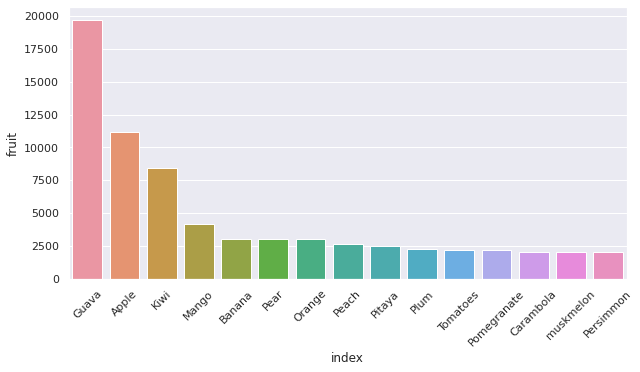

In [8]:
sns.set(rc={'figure.figsize':(10, 5)})
plt.xticks(rotation=45)
sns.barplot(data=pd.DataFrame(fruit_values(normalize=False)).reset_index(),
            x='index', y='fruit', dodge=False)

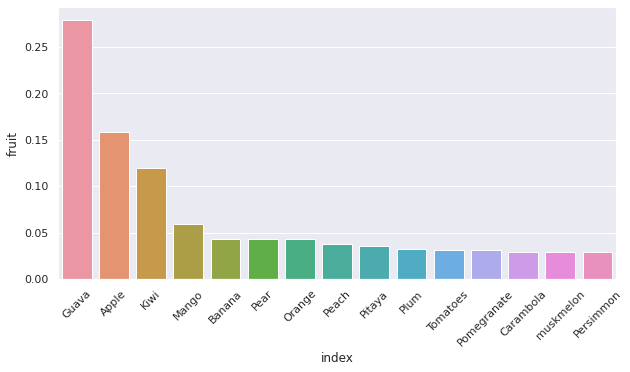

In [9]:
sns.set(rc={'figure.figsize':(10, 5)})
plt.xticks(rotation=45)
sns.barplot(data=pd.DataFrame(fruit_values(normalize=True)).reset_index(), x='index', y='fruit')

In [10]:
fruit_values(normalize=True)

Guava          0.279210
Apple          0.158542
Kiwi           0.119988
Mango          0.058881
Banana         0.042906
Pear           0.042694
Orange         0.042694
Peach          0.037265
Pitaya         0.035451
Plum           0.032573
Tomatoes       0.030773
Pomegranate    0.030716
Carambola      0.029483
muskmelon      0.029455
Persimmon      0.029370
Name: fruit, dtype: float64

## making stratified splits for train and validation

In [11]:
df.shape

(70549, 3)

In [12]:
0.05*70_549

3527.4500000000003

so, 3,528 samples have to be included in validation set.

In [13]:
from sklearn.model_selection import StratifiedShuffleSplit

In [14]:
strat_split = StratifiedShuffleSplit(n_splits=5, test_size=0.05, random_state=2)

In [15]:
for tr_index, val_index in strat_split.split(df, df.loc[:,'fruit']):
    strat_train_df = df.loc[tr_index]
    strat_valid_df = df.loc[val_index]

In [16]:
strat_train_df.shape,strat_valid_df.shape

((67021, 3), (3528, 3))

In [17]:
strat_train_df.loc[:,'fruit'].value_counts()

Guava          18713
Apple          10626
Kiwi            8042
Mango           3946
Banana          2876
Pear            2861
Orange          2861
Peach           2498
Pitaya          2376
Plum            2183
Tomatoes        2062
Pomegranate     2059
Carambola       1976
muskmelon       1974
Persimmon       1968
Name: fruit, dtype: int64

In [18]:
strat_valid_df.loc[:,'fruit'].value_counts()

Guava          985
Apple          559
Kiwi           423
Mango          208
Orange         151
Banana         151
Pear           151
Peach          131
Pitaya         125
Plum           115
Tomatoes       109
Pomegranate    108
muskmelon      104
Carambola      104
Persimmon      104
Name: fruit, dtype: int64

So, class weights has to be supplied to handle this imablance.

In [19]:
img_width=300
img_height=300


train_data_IDG = ImageDataGenerator(rotation_range=40, width_shift_range=0.2, height_shift_range=0.2, shear_range=0.2,
                                    zoom_range=0.2, fill_mode='nearest', horizontal_flip=True, rescale=1.0/255)

valid_data_IDG = ImageDataGenerator(rescale=1.0/255, validation_split=0.05)


training_data = train_data_IDG.flow_from_dataframe(dataframe=strat_train_df,
                                                   y_col='fruit', x_col='path',
                                                   target_size=(img_width,img_height), batch_size=8, shuffle=True,
                                                   class_mode='categorical')

validation_data = valid_data_IDG.flow_from_dataframe(dataframe=strat_valid_df,
                                                     y_col='fruit', x_col='path',
                                                     target_size=(img_width,img_height), shuffle=True,
                                                     class_mode='categorical')

print()
print(set(training_data.classes))
print()
print(set(validation_data.classes))

Found 67021 validated image filenames belonging to 15 classes.
Found 3528 validated image filenames belonging to 15 classes.

{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14}

{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14}


In [20]:
training_data.target_size, training_data.n, validation_data.target_size, validation_data.n

((300, 300), 67021, (300, 300), 3528)

In [21]:
training_data.image_shape, training_data.batch_size, training_data.class_mode, validation_data.image_shape, validation_data.batch_size, validation_data.class_mode

((300, 300, 3), 8, 'categorical', (300, 300, 3), 32, 'categorical')

## Data Exploration

In [22]:
tr_set_images, tr_set_labels = next(training_data)
val_set_images, val_set_labels = next(validation_data)
tr_set_images.shape, tr_set_labels.shape, val_set_images.shape, val_set_labels.shape

((8, 300, 300, 3), (8, 15), (32, 300, 300, 3), (32, 15))

Banana


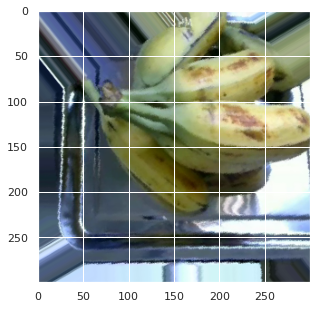

In [23]:
i = 2
print(mapped_fruit_names[np.where(tr_set_labels[i] == 1)[0][0]])
plt.imshow(X=tr_set_images[i])

Mango


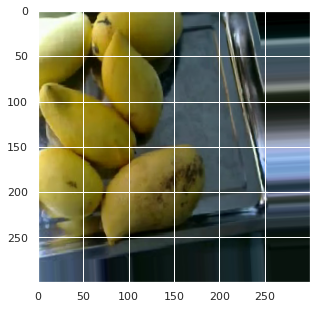

In [24]:
i = 6
print(mapped_fruit_names[np.where(tr_set_labels[i] == 1)[0][0]])
plt.imshow(X=tr_set_images[i])

Guava


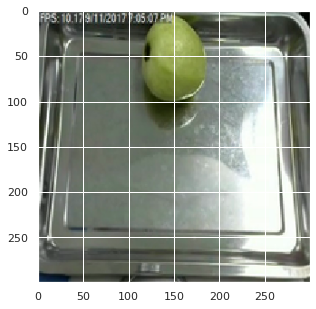

In [25]:
i = 7
print(mapped_fruit_names[np.where(val_set_labels[i] == 1)[0][0]])
plt.imshow(X=val_set_images[i])

# Modelling

## making model

In [26]:
from tensorflow.keras.applications.xception import Xception
from tensorflow.keras import layers
from tensorflow.keras import Model

In [27]:
base_xception = Xception(include_top=False, weights='imagenet', input_shape=(299,299,3), pooling='max')

inner = base_xception.output
inner = layers.Dense(units=512, activation='relu')(inner)
inner = layers.Dropout(rate=0.5)(inner)
inner = layers.Dense(units=15, activation='softmax')(inner)

model_1 = Model(inputs=base_xception.input, outputs=inner)
model_1.summary()

83689472/83683744 [==============================] - 1s 0us/step
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 149, 149, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 149, 149, 32) 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 149, 149, 32) 0           block1_conv1_bn[0][0]            
_____________________________

## compiling model

In [28]:
from tensorflow_addons.metrics import FBetaScore
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import CategoricalAccuracy, Precision, Recall
from tensorflow.keras.losses import CategoricalCrossentropy

model_1.compile(loss = CategoricalCrossentropy(),
                optimizer = Adam(),
                metrics = [FBetaScore(num_classes=15, average='macro', name='fbeta_score'),
                           CategoricalAccuracy(name='cat_acc'),
                           # GeometricMeanScore(average='weighted'),
                           Precision(name='precision'), Recall(name='recall')])

## callbacks

In [29]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

early_stop_cb = EarlyStopping(monitor='val_fbeta_score', min_delta=0, patience=4, verbose=1, mode='max')
reduce_learning_rate_cb = ReduceLROnPlateau(monitor='loss', factor=0.1, patience=2, cooldown=2, min_lr=0.00001, verbose=1)

## preparing class weights for undersampled classes

since this is going to be imbalanced classification problem, class weights for undersampled classes has to be defined.

In [30]:
new_maps_2 = pd.Series(training_data.classes).value_counts()
new_maps_2 = new_maps_2.rename("fruit")
new_maps_2

3     18713
0     10626
4      8042
5      3946
1      2876
8      2861
6      2861
7      2498
10     2376
11     2183
13     2062
12     2059
2      1976
14     1974
9      1968
Name: fruit, dtype: int64

In [31]:
new_maps = new_maps_2.to_dict()
new_maps

{3: 18713,
 0: 10626,
 4: 8042,
 5: 3946,
 1: 2876,
 8: 2861,
 6: 2861,
 7: 2498,
 10: 2376,
 11: 2183,
 13: 2062,
 12: 2059,
 2: 1976,
 14: 1974,
 9: 1968}

In [32]:
sum(new_maps.values())

67021

In [33]:
set(training_data.classes)

{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14}

In [34]:
# Scaling by total/15 helps keep the loss to a similar magnitude.
# The sum of the weights of all examples stays the same.
fruit_weights = {i:(1/new_maps[i])*(67_021)/15.0 for i in range(15)}
fruit_weights

{0: 0.4204843465713031,
 1: 1.5535697728326379,
 2: 2.2611673414304994,
 3: 0.23876805785639216,
 4: 0.5555914780734478,
 5: 1.1323027538435546,
 6: 1.5617150180589536,
 7: 1.7886575927408592,
 8: 1.5617150180589536,
 9: 2.2703590785907863,
 10: 1.880499438832772,
 11: 2.046755229806077,
 12: 2.17001780799741,
 13: 2.166860653087617,
 14: 2.263458291117866}

## fitting the model

if code fails this time, after first epoch, include geometric mean epoch

In [35]:
history_model_1 = model_1.fit(training_data,
                              validation_data=validation_data,
                              class_weight=fruit_weights,
                              verbose=1, epochs=30,
                              callbacks=[early_stop_cb, reduce_learning_rate_cb])

Epoch 1/30
8378/8378 [==============================] - 2347s 280ms/step - loss: 1.4350 - fbeta_score: 0.4253 - cat_acc: 0.4630 - precision: 0.7077 - recall: 0.3408 - val_loss: 0.6409 - val_fbeta_score: 0.7592 - val_cat_acc: 0.7871 - val_precision: 0.8281 - val_recall: 0.7333 - lr: 0.0010
Epoch 2/30
8378/8378 [==============================] - 2207s 263ms/step - loss: 0.1455 - fbeta_score: 0.9448 - cat_acc: 0.9502 - precision: 0.9590 - recall: 0.9417 - val_loss: 0.0379 - val_fbeta_score: 0.9845 - val_cat_acc: 0.9881 - val_precision: 0.9889 - val_recall: 0.9870 - lr: 0.0010
Epoch 5/30
8378/8378 [==============================] - 2203s 263ms/step - loss: 0.1173 - fbeta_score: 0.9599 - cat_acc: 0.9644 - precision: 0.9712 - recall: 0.9588 - val_loss: 0.1999 - val_fbeta_score: 0.9566 - val_cat_acc: 0.9532 - val_precision: 0.9556 - val_recall: 0.9515 - lr: 0.0010
Epoch 7/30
7432/8378 [=========================>....] - ETA: 4:03 - loss: 0.0939 - fbeta_score: 0.9662 - cat_acc: 0.9699 - precisi

In [36]:
# save the final model with all the weights
model_1.save(filepath='/kaggle/working', include_optimizer=True, save_format='.tf')

## plotting model statistics

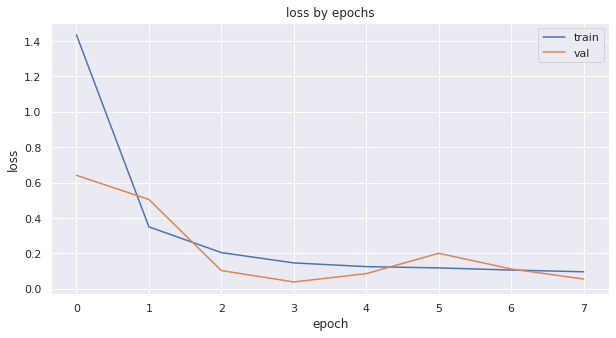

In [37]:
plt.plot(history_model_1.history['loss'])
plt.plot(history_model_1.history['val_loss'])
plt.title('loss by epochs')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='best')
plt.show()

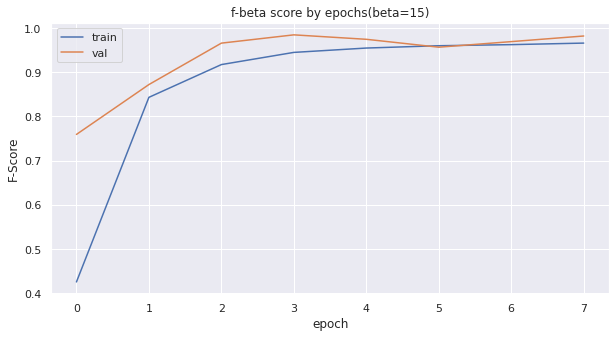

In [38]:
plt.plot(history_model_1.history['fbeta_score'])
plt.plot(history_model_1.history['val_fbeta_score'])
plt.title('f-beta score by epochs(beta=15)')
plt.ylabel('F-Score')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='best')
plt.show()

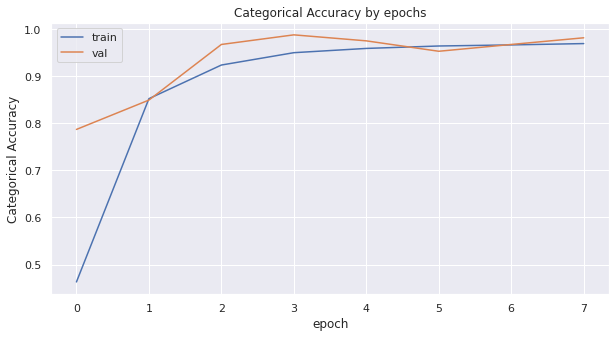

In [39]:
plt.plot(history_model_1.history['cat_acc'])
plt.plot(history_model_1.history['val_cat_acc'])
plt.title('Categorical Accuracy by epochs')
plt.ylabel('Categorical Accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='best')
plt.show()

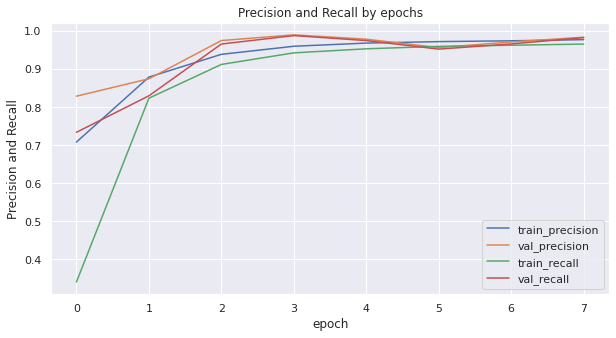

In [40]:
plt.plot(history_model_1.history['precision'])
plt.plot(history_model_1.history['val_precision'])
plt.plot(history_model_1.history['recall'])
plt.plot(history_model_1.history['val_recall'])
plt.title('Precision and Recall by epochs')
plt.ylabel('Precision and Recall')
plt.xlabel('epoch')
plt.legend(['train_precision', 'val_precision','train_recall', 'val_recall'], loc='best')
plt.show()